# Import necessary libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_profiling
import collections
import random
import lightgbm as lgb
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from ipywidgets import Image
from io import StringIO
from datetime import datetime

!pip install feature_selector
from feature_selector import FeatureSelector

!pip install shap
import shap

import os
print(os.listdir("../input"))

    100% |████████████████████████████████| 716kB 20.2MB/s 
    100% |████████████████████████████████| 12.2MB 3.2MB/s 
    100% |████████████████████████████████| 11.8MB 2.5MB/s 
    100% |████████████████████████████████| 15.0MB 2.1MB/s 
    100% |████████████████████████████████| 184kB 35.2MB/s 
    100% |████████████████████████████████| 12.4MB 3.2MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/26/0a/44/53ddd89769e62f7c6691976375b86c6492e7dd20a2d3970e32
Successfully built seaborn
yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.1 which is incompatible.
spacy 2.1.3 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
mizani 0.5.4 has requirement pandas>=0.23.4, but you'll have pandas 0.23.1 which is incompatible.
lime 0.1.1.33 has requirement matplotlib==2.1.0, but you'll have matplotlib 2.1.2 which is incompatible.
kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-lear

# Read the data

Since these are both big datasets(around 40 million instances), one of the bigger challenges was working them due to memory constrains. Since our initial goal is to analize the data, I decided to only load 10% of the reaining set.

In [2]:
p = 0.2  # 20% of the lines
# keep the header, then take only 20% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
train = pd.read_csv('../input/train_v2.csv',header=0,
                    skiprows=lambda i: i>0 and random.random() > p)

test = pd.read_csv('../input/test_v2.csv')

In [3]:
train.head()

,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,C18,C19,C20,C21,amount,isfraud
0,1,1413851817483,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,0,35,100084,79,184.09,0
1,3,1413851283020,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,0,35,100084,79,184.09,0
2,12,1413852876323,0d3cb7be,9e8cf15d,f028772b,ecad2386,a99f214a,320,50,2161,0,35,100148,157,211.16,0
3,19,1413851658805,c4e18dd6,85f751fd,50e219e0,66a5f0f3,a99f214a,320,50,2434,3,163,100088,61,191.77,0
4,21,1413851622389,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,0,35,-1,79,184.09,0


In [4]:
test.head()

,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,C18,C19,C20,C21,amount
0,32263877,1414540656054,c4e18dd6,85f751fd,50e219e0,92f5800b,a99f214a,320,50,2424,1,161,100193,71,191.77
1,32263886,1414540614666,968765cd,6399eda6,f028772b,ecad2386,a99f214a,320,50,2526,0,167,100075,221,200.45
2,32263890,1414540692012,7e091613,e151e245,f028772b,ecad2386,a99f214a,320,50,1872,3,39,-1,23,169.51
3,32263895,1414540720045,7e091613,e151e245,f028772b,ecad2386,a99f214a,320,50,1872,3,39,-1,23,169.51
4,32263896,1414540641750,c4e18dd6,85f751fd,50e219e0,73206397,cc6c0613,320,50,2665,0,35,-1,221,191.77


# Fill missing values

In [5]:
train.replace({'C20': -1}, np.nan, inplace=True)
test.replace({'C20': -1}, np.nan, inplace=True)

train_mean = int(train.C20.mean())

train.replace({'C20': np.nan}, train_mean, inplace=True)
test.replace({'C20': np.nan}, train_mean, inplace=True)

train['C20'] = train['C20'].astype('int32')
test['C20'] = test['C20'].astype('int32')

print('Replaced all the missing values found in C20 with {}'.format(train_mean))

Replaced all the missing values found in C20 with 100111


In [6]:
train.isnull().sum()

id                    0
timestamp             0
product_id            0
product_department    0
product_category      0
card_id               0
user_id               0
C15                   0
C16                   0
C17                   0
C18                   0
C19                   0
C20                   0
C21                   0
amount                0
isfraud               0
dtype: int64

In [7]:
test.isnull().sum()

id                    0
timestamp             0
product_id            0
product_department    0
product_category      0
card_id               0
user_id               0
C15                   0
C16                   0
C17                   0
C18                   0
C19                   0
C20                   0
C21                   0
amount                0
dtype: int64

In [8]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,6.47121e+06,NaN,NaN,NaN,1.61879e+07,9.34278e+06,1,8.10147e+06,1.61897e+07,2.42745e+07,3.23774e+07
timestamp,6.47121e+06,NaN,NaN,NaN,1.41419e+12,2.11041e+08,1.41385e+12,1.41399e+12,1.41417e+12,1.41438e+12,1.41454e+12
product_id,6471213,4866,c4e18dd6,2332190,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_department,6471213,3672,85f751fd,2248265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_category,6471213,23,50e219e0,2560244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
card_id,6471213,5560,ecad2386,4222948,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,6471213,715312,a99f214a,5347841,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C15,6.47121e+06,NaN,NaN,NaN,318.778,21.7368,120,320,320,320,1024
C16,6.47121e+06,NaN,NaN,NaN,60.4015,47.9234,20,50,50,50,1024
C17,6.47121e+06,NaN,NaN,NaN,2057.58,610.379,112,1800,2281,2502,2688


# Transform the Unix timestamp in datetime format

In [9]:
def format_date_time(timestamp):
    date_time_converted = datetime.utcfromtimestamp(timestamp/1000).strftime('%Y-%m-%d %H:%M:%S.%f')
    return date_time_converted

In [10]:
%%time
train['date_time'] = train.timestamp.apply(format_date_time)
test['date_time'] = test.timestamp.apply(format_date_time)
train['date_time'] = pd.to_datetime(train['date_time'])
test['date_time'] = pd.to_datetime(test['date_time'])

CPU times: user 1min, sys: 2.34 s, total: 1min 2s
Wall time: 1min 2s


### Split datetime in weekday, day of the year, hour, minute, second and millisecond

In [11]:
train['weekday'] = train['date_time'].dt.weekday.astype('int8')
train['day_of_year'] = train['date_time'].dt.dayofyear.astype('int16')
train['hour'] = train['date_time'].dt.hour.astype('int8')
train['minute'] = train['date_time'].dt.minute.astype('int8')
train['second'] = train['date_time'].dt.second.astype('int8')
train['millisecond'] = train['date_time'].dt.microsecond / 1000
train['millisecond'] = train['millisecond'].astype('int16')

train.sort_values('timestamp', axis=0, ascending=True, inplace=True)

train.head()

,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,C18,C19,C20,C21,amount,isfraud,date_time,weekday,day_of_year,hour,minute,second,millisecond
16534,82336,1413849600012,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,0,35,100111,79,184.09,0,2014-10-21 00:00:00.012,1,294,0,0,0,12
6211,30628,1413849600466,92c9e92d,518d6168,f028772b,ecad2386,a99f214a,320,50,2161,0,35,100111,157,211.90,0,2014-10-21 00:00:00.466,1,294,0,0,0,466
14072,69965,1413849600489,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,0,35,100111,79,184.09,0,2014-10-21 00:00:00.489,1,294,0,0,0,489
3030,15220,1413849600617,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,0,35,100084,79,184.09,0,2014-10-21 00:00:00.617,1,294,0,0,0,617
17356,86647,1413849600638,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,0,35,100111,79,184.09,1,2014-10-21 00:00:00.638,1,294,0,0,0,638


In [12]:
test['weekday'] = test['date_time'].dt.weekday.astype('int8')
test['day_of_year'] = test['date_time'].dt.dayofyear.astype('int16')
test['hour'] = test['date_time'].dt.hour.astype('int8')
test['minute'] = test['date_time'].dt.minute.astype('int8')
test['second'] = test['date_time'].dt.second.astype('int8')
test['millisecond'] = test['date_time'].dt.microsecond / 1000
test['millisecond'] = test['millisecond'].astype('int16')

test.sort_values('timestamp', axis=0, ascending=True, inplace=True)

test.head()

,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,C18,C19,C20,C21,amount,date_time,weekday,day_of_year,hour,minute,second,millisecond
2314,32296749,1414540545846,7e091613,e151e245,f028772b,ecad2386,a99f214a,320,50,2647,2,35,100148,23,169.51,2014-10-28 23:55:45.846,1,301,23,55,45,846
5770,32345945,1414540545876,6b59f079,12fb4121,f028772b,ecad2386,a99f214a,320,50,2682,1,419,100111,212,218.20,2014-10-28 23:55:45.876,1,301,23,55,45,876
1247,32281182,1414540545886,c4e18dd6,85f751fd,50e219e0,3e2bf98d,58132d0c,320,50,2647,2,35,100148,23,191.77,2014-10-28 23:55:45.886,1,301,23,55,45,886
2132,32294155,1414540545936,6b59f079,12fb4121,f028772b,ecad2386,a99f214a,320,50,2682,1,419,100084,212,218.20,2014-10-28 23:55:45.936,1,301,23,55,45,936
6611,32358193,1414540545969,c4e18dd6,85f751fd,50e219e0,ce183bbd,a99f214a,320,50,2597,1,167,100003,71,191.77,2014-10-28 23:55:45.969,1,301,23,55,45,969


# Data visualization

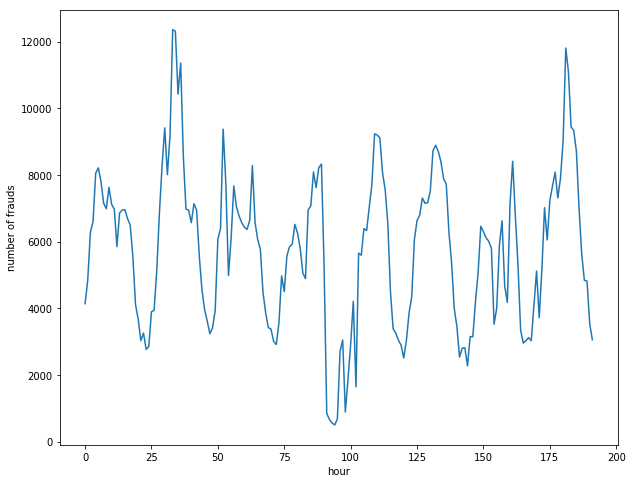

In [13]:
fraud_per_hour = []
for (day, hour), sub_df in train.groupby(['day_of_year', 'hour']):
    fraud_per_hour.append((sub_df['isfraud'] == 1).sum())
    
plt.figure(figsize=(10,8))
plt.plot(fraud_per_hour)
plt.ylabel('number of frauds')
plt.xlabel('hour')
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


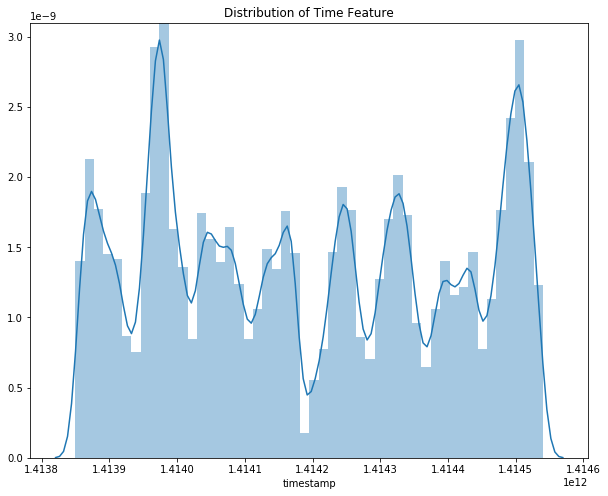

In [14]:
#visualizations of time
plt.figure(figsize=(10,8))
plt.title('Distribution of Time Feature')
sns.distplot(train.timestamp)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


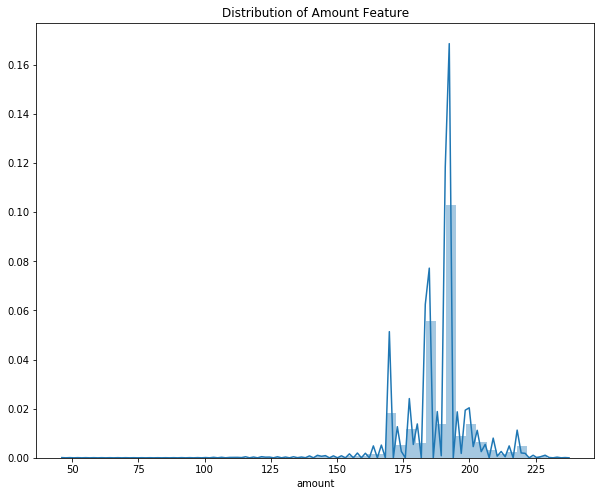

In [15]:
plt.figure(figsize=(10,8))
plt.title('Distribution of Amount Feature')
sns.distplot(train.amount)

There were 5361311 non-fraudulent transactions (82.849%) and 1109902 fraudulent transactions (17.151%).


Text(0.5, 0, 'Class (0:Non-Fraudulent, 1:Fraudulent)')

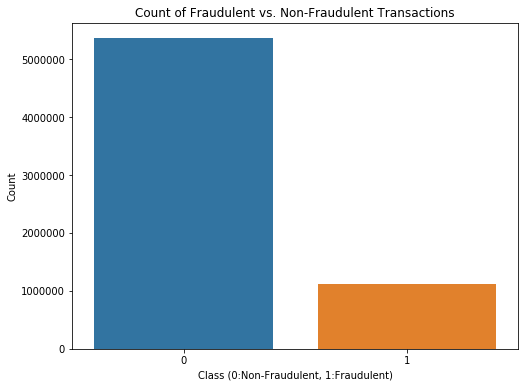

In [16]:
#fraud vs. normal transactions 
counts = train.isfraud.value_counts()
normal = counts[0]
fraudulent = counts[1]
perc_normal = (normal/(normal+fraudulent))*100
perc_fraudulent = (fraudulent/(normal+fraudulent))*100
print('There were {} non-fraudulent transactions ({:.3f}%) and {} fraudulent transactions ({:.3f}%).'.format(normal, perc_normal, fraudulent, perc_fraudulent))

plt.figure(figsize=(8,6))
sns.barplot(x=counts.index, y=counts)
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Fraudulent, 1:Fraudulent)')

As we can see, the non-fraud transactions far outweigh the fraud transactions. If we train a without fixing this problem, the model will be biased towards the dominant class.

# Transform time features in cyclical features

Hours of the day, days of the week, months in a year, and wind direction are all examples of features that are cyclical. We need to convert these features into a representation that can preserve information such as hour 23 and hour 0 being close to each other and not far.

In [17]:
train['weekday_sin'] = np.sin(train.weekday*(2.*np.pi/7))
train['weekday_cos'] = np.cos(train.weekday*(2.*np.pi/7))
train['day_of_year_sin'] = np.sin(train.day_of_year*(2.*np.pi/365))
train['day_of_year_cos'] = np.cos(train.day_of_year*(2.*np.pi/365))
train['hour_sin'] = np.sin(train.hour*(2.*np.pi/24))
train['hour_cos'] = np.cos(train.hour*(2.*np.pi/24))
train['minute_sin'] = np.sin(train.minute*(2.*np.pi/60))
train['minute_cos'] = np.cos(train.minute*(2.*np.pi/60))
train['second_sin'] = np.sin(train.second*(2.*np.pi/60))
train['second_cos'] = np.cos(train.second*(2.*np.pi/60))
train['millisecond_sin'] = np.sin(train.millisecond*(2.*np.pi/1000))
train['millisecond_cos'] = np.cos(train.millisecond*(2.*np.pi/1000))

test['weekday_sin'] = np.sin(train.weekday*(2.*np.pi/7))
test['weekday_cos'] = np.cos(train.weekday*(2.*np.pi/7))
test['day_of_year_sin'] = np.sin(test.day_of_year*(2.*np.pi/365))
test['day_of_year_cos'] = np.cos(test.day_of_year*(2.*np.pi/365))
test['hour_sin'] = np.sin(test.hour*(2.*np.pi/24))
test['hour_cos'] = np.cos(test.hour*(2.*np.pi/24))
test['minute_sin'] = np.sin(test.minute*(2.*np.pi/60))
test['minute_cos'] = np.cos(test.minute*(2.*np.pi/60))
test['second_sin'] = np.sin(test.second*(2.*np.pi/60))
test['second_cos'] = np.cos(test.second*(2.*np.pi/60))
test['millisecond_sin'] = np.sin(test.millisecond*(2.*np.pi/1000))
test['millisecond_cos'] = np.cos(test.millisecond*(2.*np.pi/1000))

drop_columns = ['weekday', 'day_of_year', 'hour', 'minute', 'second', 'millisecond', 'date_time']
train.drop(drop_columns, inplace=True, axis=1)
test.drop(drop_columns, inplace=True, axis=1)

# Create the profiling document

Although both profiles were only made with 1% of the training dataset, because of the lack of computing resources, these give us a great overall knowledge of the dataset. The interactive nature of the HTML file was a great plus when the time came to do a presentation of the data analysis. 

Check the following HTML files to see the developed reports(use the links bellow to open them in interactive mode with https://htmlpreview.github.io/ ):

- [pandas_profiling.html](http://htmlpreview.github.io/?https://github.com/HROlive/Feedzai-Catch-the-Fraudster/blob/master/pandas_profiling.html) - before the conversion to cyclical features
- [pandas_profiling_cyclical.html](http://htmlpreview.github.io/?https://github.com/HROlive/Feedzai-Catch-the-Fraudster/blob/master/pandas_profiling_cyclical.html) - after the conversion to cyclical features

For each column the following statistics - if relevant for the column type - are presented in an interactive HTML report:

- Essentials: type, unique values, missing values
- Quantile statistics like minimum value, Q1, median, Q3, maximum, range, interquartile range
- Descriptive statistics like mean, mode, standard deviation, sum, median absolute deviation, coefficient of variation, kurtosis, skewness
- Most frequent values
- Histogram
- Correlations highlighting of highly correlated variables, Spearman, Pearson and Kendall matrices
- Missing values matrix, count, heatmap and dendrogram of missing values

**Note:** We should balance our dataset before we analize the correlations between features because our results will be affected by this problem. A few approaches that would help us tackle the problem at the data point level are undersampling, oversampling, and feature selection.

In [ ]:
%%time
profile = pandas_profiling.ProfileReport(train, plot={'histogram':{'bayesian_blocks_bins': True}},
                                         check_correlation_pearson=True, correlations={'pearson': True,
                                                                                       'spearman': True,
                                                                                       'kendall': True,
                                                                                       'phi_k': True,
                                                                                       'cramers': True,
                                                                                       'recoded':False})

profile.to_file('C:/Projets/Feedzai/pandas_profiling.html.html')

# Encode categorical features

In [18]:
lb_make = LabelEncoder()

features_to_encode = ['product_id', "product_department", "product_category", "card_id", "user_id"]

for c in features_to_encode:
    frames = [train[c], test[c]]
    result = pd.concat(frames)
    lb_make.fit(result)
    train[c] = lb_make.transform(train[c])
    test[c] = lb_make.transform(test[c])

# Feature Correlations

**Note:** As stated previously, we should balance our dataset before we analize the correlations between features because our results will be affected by this problem. A few approaches that would help us tackle the problem at the data point level are undersampling, oversampling, and feature selection. 

The method bellow won't help us with it, it's just the calculation of the scale_pos_weight parameter for the LightGBM model.

In [ ]:
#pos_count = y_train.sum()
#neg_count = len(y_train) - pos_count
#imbalance_ratio = neg_count / pos_count
    
#scale_pos_weight = imbalance_ratio

Text(0.5, 1.0, 'Heatmap of Correlation')

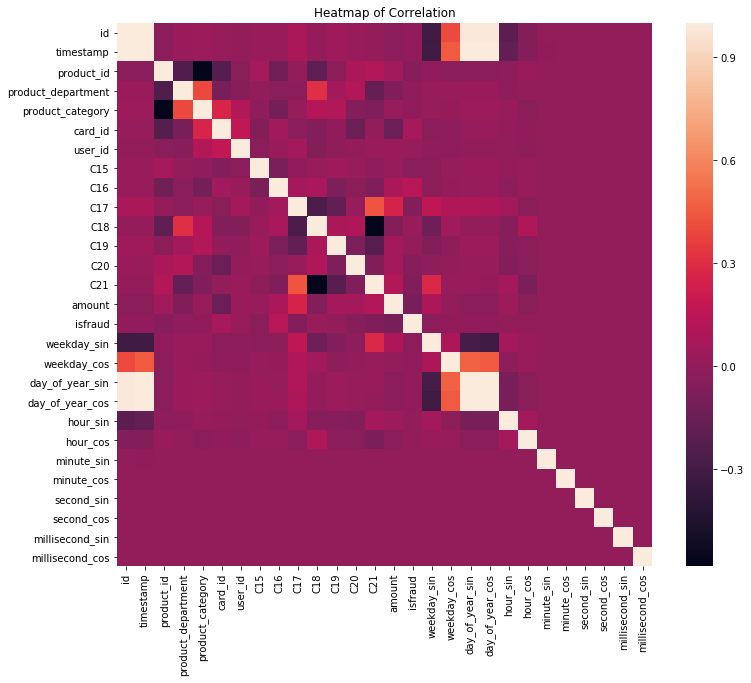

In [19]:
#heatmap
corr = train.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr)
plt.title('Heatmap of Correlation')

# Reduce memory usage
As stated previously, one of the biggest challenges was handling the size of the dataset, with such a small amount of memory(RAM) at our disposal. With this in mind, the following function, modifies the datatype of each column(if possible) to reduce the memory usage of the dataframe.

In [20]:
def reduce_mem_usage(df):
    """ 
    Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:

        col_type = df[col].dtype

        if col_type != object:

            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [21]:
reduce_mem_usage(train)

Memory usage of dataframe is 1727.09 MB
Memory usage after optimization is: 770.51 MB
Decreased by 55.4%


,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,C18,C19,C20,C21,amount,isfraud,weekday_sin,weekday_cos,day_of_year_sin,day_of_year_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,millisecond_sin,millisecond_cos
16534,82336,1413849600012,5500,513,1,5996,830998,320,50,1722,0,35,100111,79,184.125,0,0.781738,0.623535,-0.939941,0.341553,0.000000,1.00000,0.0,1.000000,0.000000,1.000000,0.075317,0.997070
6211,30628,1413849600466,3372,1366,22,5996,830998,320,50,2161,0,35,100111,157,211.875,0,0.781738,0.623535,-0.939941,0.341553,0.000000,1.00000,0.0,1.000000,0.000000,1.000000,0.212036,-0.977051
14072,69965,1413849600489,5500,513,1,5996,830998,320,50,1722,0,35,100111,79,184.125,0,0.781738,0.623535,-0.939941,0.341553,0.000000,1.00000,0.0,1.000000,0.000000,1.000000,0.069031,-0.997559
3030,15220,1413849600617,5500,513,1,5996,830998,320,50,1722,0,35,100084,79,184.125,0,0.781738,0.623535,-0.939941,0.341553,0.000000,1.00000,0.0,1.000000,0.000000,1.000000,-0.670898,-0.741699
17356,86647,1413849600638,5500,513,1,5996,830998,320,50,1722,0,35,100111,79,184.125,1,0.781738,0.623535,-0.939941,0.341553,0.000000,1.00000,0.0,1.000000,0.000000,1.000000,-0.762207,-0.646973
7490,36753,1413849600851,5500,513,1,5996,830998,320,50,1722,0,35,100084,79,184.125,0,0.781738,0.623535,-0.939941,0.341553,0.000000,1.00000,0.0,1.000000,0.000000,1.000000,-0.805176,0.592773
16480,82066,1413849600863,5500,513,1,5996,830998,320,50,1722,0,35,100111,79,184.125,0,0.781738,0.623535,-0.939941,0.341553,0.000000,1.00000,0.0,1.000000,0.000000,1.000000,-0.758301,0.651855
4634,23105,1413849600895,2264,3852,22,5996,830998,320,50,2161,0,35,100111,157,202.250,0,0.781738,0.623535,-0.939941,0.341553,0.000000,1.00000,0.0,1.000000,0.000000,1.000000,-0.612793,0.790039
17044,84977,1413849601016,3509,3475,22,5996,830998,320,50,1722,0,35,100111,79,177.625,0,0.781738,0.623535,-0.939941,0.341553,0.000000,1.00000,0.0,1.000000,0.104553,0.994629,0.100342,0.995117
11510,57326,1413849601118,4488,2151,5,5748,830998,320,50,576,2,35,100111,32,191.750,0,0.781738,0.623535,-0.939941,0.341553,0.000000,1.00000,0.0,1.000000,0.104553,0.994629,0.675293,0.737305


In [22]:
reduce_mem_usage(test)

Memory usage of dataframe is 1690.94 MB
Memory usage after optimization is: 553.40 MB
Decreased by 67.3%


,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,C18,C19,C20,C21,amount,weekday_sin,weekday_cos,day_of_year_sin,day_of_year_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,millisecond_sin,millisecond_cos
2314,32296749,1414540545846,2909,3585,22,5996,830998,320,50,2647,2,35,100148,23,169.500,0.781738,0.623535,-0.892090,0.452148,-0.258789,0.96582,-0.500000,0.866211,-1.000000,-0.000000,-0.823730,0.567383
5770,32345945,1414540545876,2478,302,22,5996,830998,320,50,2682,1,419,100111,212,218.250,0.781738,0.623535,-0.892090,0.452148,-0.258789,0.96582,-0.500000,0.866211,-1.000000,-0.000000,-0.702637,0.711426
1247,32281182,1414540545886,4488,2151,5,1564,430738,320,50,2647,2,35,100148,23,191.750,0.781738,0.623535,-0.892090,0.452148,-0.258789,0.96582,-0.500000,0.866211,-1.000000,-0.000000,-0.656738,0.754395
2132,32294155,1414540545936,2478,302,22,5996,830998,320,50,2682,1,419,100084,212,218.250,0.781738,0.623535,-0.892090,0.452148,-0.258789,0.96582,-0.500000,0.866211,-1.000000,-0.000000,-0.391357,0.920410
6611,32358193,1414540545969,4488,2151,5,5230,830998,320,50,2597,1,167,100003,71,191.750,0.781738,0.623535,-0.892090,0.452148,-0.258789,0.96582,-0.500000,0.866211,-1.000000,-0.000000,-0.193604,0.980957
648,32272669,1414540546010,5500,513,1,5996,830998,320,50,2617,0,35,100111,51,184.125,0.781738,0.623535,-0.892090,0.452148,-0.258789,0.96582,-0.500000,0.866211,-0.994629,0.104553,0.062805,0.998047
4336,32325104,1414540546100,2478,302,22,5996,830998,320,50,2683,1,163,100111,212,218.250,0.781738,0.623535,-0.892090,0.452148,-0.258789,0.96582,-0.500000,0.866211,-0.994629,0.104553,0.587891,0.809082
7370,32369681,1414540546107,5500,513,1,5996,830998,320,50,2545,0,167,100084,221,184.125,0.781738,0.623535,-0.892090,0.452148,-0.258789,0.96582,-0.500000,0.866211,-0.994629,0.104553,0.622559,0.782227
4159,32322661,1414540546135,2909,3585,22,5996,830998,320,50,2647,2,35,100148,23,169.500,0.781738,0.623535,-0.892090,0.452148,-0.258789,0.96582,-0.500000,0.866211,-0.994629,0.104553,0.750000,0.661133
3730,32316628,1414540546201,5500,513,1,5996,830998,320,50,2617,0,35,100111,51,184.125,0.781738,0.623535,-0.892090,0.452148,-0.258789,0.96582,-0.500000,0.866211,-0.994629,0.104553,0.953125,0.302979


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6471213 entries, 16534 to 6450504
Data columns (total 28 columns):
id                    int32
timestamp             int64
product_id            int16
product_department    int16
product_category      int8
card_id               int16
user_id               int32
C15                   int16
C16                   int16
C17                   int16
C18                   int8
C19                   int16
C20                   int32
C21                   int16
amount                float16
isfraud               int8
weekday_sin           float16
weekday_cos           float16
day_of_year_sin       float16
day_of_year_cos       float16
hour_sin              float16
hour_cos              float16
minute_sin            float16
minute_cos            float16
second_sin            float16
second_cos            float16
millisecond_sin       float16
millisecond_cos       float16
dtypes: float16(13), int16(8), int32(3), int64(1), int8(3)
memory usage: 770

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8059443 entries, 2314 to 8054427
Data columns (total 27 columns):
id                    int32
timestamp             int64
product_id            int16
product_department    int16
product_category      int8
card_id               int16
user_id               int32
C15                   int16
C16                   int16
C17                   int16
C18                   int8
C19                   int16
C20                   int32
C21                   int16
amount                float16
weekday_sin           float16
weekday_cos           float16
day_of_year_sin       float16
day_of_year_cos       float16
hour_sin              float16
hour_cos              float16
minute_sin            float16
minute_cos            float16
second_sin            float16
second_cos            float16
millisecond_sin       float16
millisecond_cos       float16
dtypes: float16(13), int16(8), int32(3), int64(1), int8(2)
memory usage: 553.4 MB


In [25]:
#train.product_id = train.product_id.astype('category')
#test.product_id = test.product_id.astype('category')
#train.product_department = train.product_department.astype('category')
#test.product_department = test.product_department.astype('category')
#train.product_category = train.product_category.astype('category')
#test.product_category = test.product_category.astype('category')
#train.card_id = train.card_id.astype('category')
#test.card_id = test.card_id.astype('category')
#train.user_id = train.user_id.astype('category')
#test.user_id = test.user_id.astype('category')

# Feature Selector

Using the FeatureSelector library, we do a deeper analysis of the dataset which allows us to find the features to drop according to specified criteria. This library has five functions for identifying columns to remove:

- identify_missing # Features with a high percentage of missing values
- identify_single_unique # Features with a single unique value
- identify_collinear # Collinear (highly correlated) features
- identify_zero_importance # Features with zero importance in a tree-based model
- identify_low_importance # Features with low importance

The identified features are stored in the ops attribute (a Python dictionary) of the FeatureSelector. We can remove the identified features manually or use the remove function in the FeatureSelector for actually removing the features.

In [26]:
train_labels = train['isfraud']
train = train.drop(columns = ['isfraud'])

In [27]:
fs = FeatureSelector(data = train, labels = train_labels)

### Collinear Features

From our previous analysis, we already know that we don't have features with missing values or with a single unique value, so we skip the first 2 methods.
This way we can start with the method finds pairs of collinear features based on the Pearson correlation coefficient. For each pair above the specified threshold (in terms of absolute value), it identifies one of the variables to be removed. We need to pass in a correlation_threshold, which in this case is 0.98.

In [28]:
fs.identify_collinear(correlation_threshold=0.98)

3 features with a correlation magnitude greater than 0.98.



In [29]:
correlated_features = fs.ops['collinear']
correlated_features[:5]

['timestamp', 'day_of_year_sin', 'day_of_year_cos']

In [30]:
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,timestamp,id,0.997734
1,day_of_year_sin,id,0.987838
2,day_of_year_sin,timestamp,0.994129
3,day_of_year_cos,id,0.990101
4,day_of_year_cos,timestamp,0.994913


### Zero Importance Features

This method relies on a machine learning model to identify features to remove and, therefore requires a supervised learning problem with labels. It works by finding feature importances using a gradient boosting machine implemented in the LightGBM library.

To reduce variance in the calculated feature importances, the model is trained a default 10 times. The model is also by default trained with early stopping using a validation set (15% of the training data) to identify the optimal number of estimators to train.

**Note of caution:** in contrast to the first 3 methods, this and the next method(identify_low_importance) builds on the gradient boosting model feature importances which are non-deterministic (have a little randomness). The results of running this method can change each time, so it's advised running these two methods several times with varying parameters and testing each resulting set of features rather than picking one number and sticking to it.

In [31]:
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                            early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.401882	valid_0's auc: 0.744117
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.40053	valid_0's auc: 0.744352
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[999]	valid_0's binary_logloss: 0.401172	valid_0's auc: 0.74446
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.401679	valid_0's auc: 0.744063
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[997]	valid_0's binary_logloss: 0.401328	valid_0's auc: 0.744003
Training until validation scores don't improve for 100 rounds.
Did not meet early sto

In [32]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 27 original features
There are 0 one-hot features


In [33]:
fs.data_all.head(10)

,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,C18,C19,C20,C21,amount,weekday_sin,weekday_cos,day_of_year_sin,day_of_year_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,millisecond_sin,millisecond_cos
16534,82336,1413849600012,5500,513,1,5996,830998,320,50,1722,0,35,100111,79,184.125,0.781738,0.623535,-0.939941,0.341553,0.0,1.0,0.0,1.0,0.000000,1.000000,0.075317,0.997070
6211,30628,1413849600466,3372,1366,22,5996,830998,320,50,2161,0,35,100111,157,211.875,0.781738,0.623535,-0.939941,0.341553,0.0,1.0,0.0,1.0,0.000000,1.000000,0.212036,-0.977051
14072,69965,1413849600489,5500,513,1,5996,830998,320,50,1722,0,35,100111,79,184.125,0.781738,0.623535,-0.939941,0.341553,0.0,1.0,0.0,1.0,0.000000,1.000000,0.069031,-0.997559
3030,15220,1413849600617,5500,513,1,5996,830998,320,50,1722,0,35,100084,79,184.125,0.781738,0.623535,-0.939941,0.341553,0.0,1.0,0.0,1.0,0.000000,1.000000,-0.670898,-0.741699
17356,86647,1413849600638,5500,513,1,5996,830998,320,50,1722,0,35,100111,79,184.125,0.781738,0.623535,-0.939941,0.341553,0.0,1.0,0.0,1.0,0.000000,1.000000,-0.762207,-0.646973
7490,36753,1413849600851,5500,513,1,5996,830998,320,50,1722,0,35,100084,79,184.125,0.781738,0.623535,-0.939941,0.341553,0.0,1.0,0.0,1.0,0.000000,1.000000,-0.805176,0.592773
16480,82066,1413849600863,5500,513,1,5996,830998,320,50,1722,0,35,100111,79,184.125,0.781738,0.623535,-0.939941,0.341553,0.0,1.0,0.0,1.0,0.000000,1.000000,-0.758301,0.651855
4634,23105,1413849600895,2264,3852,22,5996,830998,320,50,2161,0,35,100111,157,202.250,0.781738,0.623535,-0.939941,0.341553,0.0,1.0,0.0,1.0,0.000000,1.000000,-0.612793,0.790039
17044,84977,1413849601016,3509,3475,22,5996,830998,320,50,1722,0,35,100111,79,177.625,0.781738,0.623535,-0.939941,0.341553,0.0,1.0,0.0,1.0,0.104553,0.994629,0.100342,0.995117
11510,57326,1413849601118,4488,2151,5,5748,830998,320,50,576,2,35,100111,32,191.750,0.781738,0.623535,-0.939941,0.341553,0.0,1.0,0.0,1.0,0.104553,0.994629,0.675293,0.737305


In [34]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features[10:15]

[]

#### Plot Features Importances

The feature importance plot using plot_feature_importances will show us the plot_n most important features (on a normalized scale where the features sum to 1). It also shows us the cumulative feature importance versus the number of features.

When we plot the feature importances, we can pass in a threshold which identifies the number of features required to reach a specified cumulative feature importance. For example, threshold = 0.99 will tell us the number of features needed to account for 99% of the total importance.

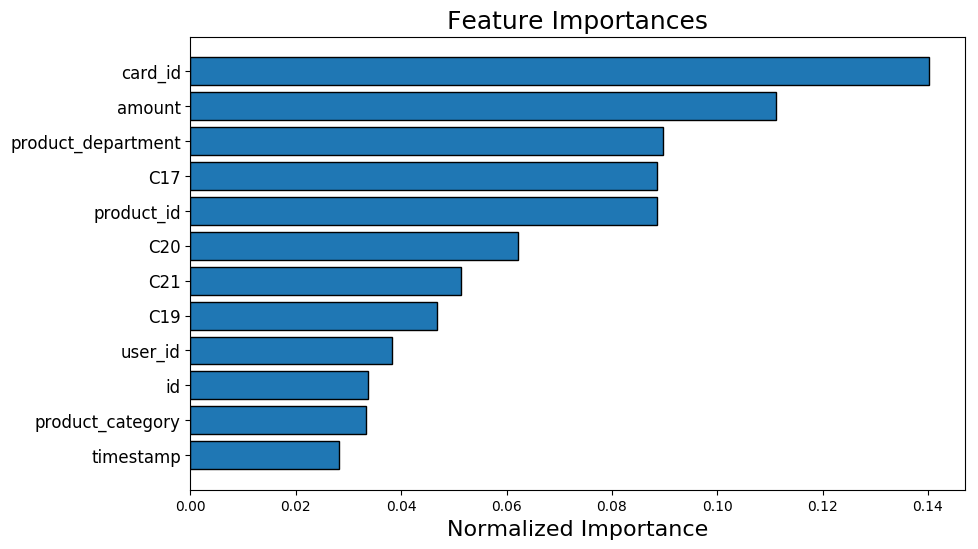

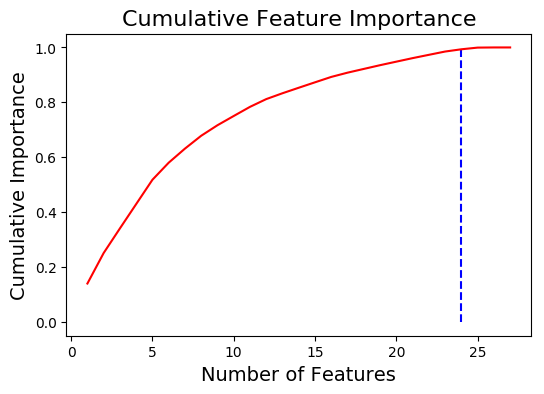

24 features required for 0.99 of cumulative importance


In [35]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [36]:
fs.feature_importances.head(27)

,feature,importance,normalized_importance,cumulative_importance
0,card_id,4201.6,0.140123,0.140123
1,amount,3334.3,0.111199,0.251322
2,product_department,2688.3,0.089655,0.340977
3,C17,2657.3,0.088621,0.429598
4,product_id,2655.2,0.088551,0.518149
5,C20,1862.9,0.062128,0.580277
6,C21,1537.8,0.051286,0.631562
7,C19,1405.7,0.046880,0.678443
8,user_id,1147.6,0.038272,0.716715
9,id,1009.7,0.033674,0.750389


In [37]:
one_hundred_features = list(fs.feature_importances.loc[:99, 'feature'])
len(one_hundred_features)

27

### Low Importance Features

This method builds off the feature importances from the gradient boosting machine (identify_zero_importance must be run first) by finding the lowest importance features not needed to reach a specified cumulative total feature importance. For example, if we pass in 0.99, this will find the lowest important features that are not needed to reach 99% of the total feature importance.

When using this method, we must have already run identify_zero_importance and need to pass in a cumulative_importance that accounts for that fraction of total feature importance.

In [38]:
fs.identify_low_importance(cumulative_importance = 0.99)

23 features required for cumulative importance of 0.99 after one hot encoding.
4 features do not contribute to cumulative importance of 0.99.



In [39]:
low_importance_features = fs.ops['low_importance']
low_importance_features[:5]

['weekday_sin', 'weekday_cos', 'day_of_year_sin', 'day_of_year_cos']

# Removing Features

Once we have identified the features to remove, we have a number of ways to drop the features. We can access any of the feature lists in the removal_ops dictionary and remove the columns manually. We also can use the remove method, passing in the methods that identified the features we want to remove.

This method returns the resulting data which we can then use for machine learning. The original data will still be accessible in the data attribute of the Feature Selector.

To remove the features from all of the methods, pass in method='all'. Before we do this, we can check how many features will be removed using check_removal. This returns a list of all the features that have been idenfitied for removal.

In [40]:
all_to_remove = fs.check_removal()
all_to_remove[10:25]

Total of 5 features identified for removal


[]

In [41]:
train_removed_all = fs.remove(methods = 'all', keep_one_hot=False)

['collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 5 features including one-hot features.


In [42]:
print('Original Number of Features', train.shape[1])
print('Final Number of Features: ', train_removed_all.shape[1])

Original Number of Features 27
Final Number of Features:  22


# Feature explanation

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model.

In [ ]:
%time shap_values = shap.TreeExplainer(fs.model).shap_values(valid_features)

In [ ]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], train.iloc[0,:], matplotlib=True)

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, train)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, train)

In [ ]:
shap.summary_plot(shap_values, train, plot_type="bar")

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("card_id", shap_values, train)